In [1]:
import pandas as pd
import pickle
import numpy as np
import itertools
import random
import copy
import collections
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from fuzzywuzzy import fuzz
from ipywidgets import interact

In [2]:
data_combined = pickle.load(open('/data/BobbyDobo/data_combined.p', 'rb'))
flattened_rec_item = pickle.load(open('/data/BobbyDobo/flattened_rec_item.p', 'rb'))
ingredient_relations = pickle.load(open('/data/BobbyDobo/ingredient_relations.p', 'rb'))

In [3]:
flattened_rec_item
ingredient_relations;

## Most Common Ingredients
Exploring the most used ingredients in the recipe list

In [4]:
#exploring most used ingredients in recipe list
cleaned = pd.DataFrame(flattened_rec_item, columns=["id","ingredient"])
ingredients = cleaned.groupby('ingredient')
counts = ingredients.count()
counts['per'] = counts['id']/counts['id'].sum()
counts = counts.sort_values('per', ascending = False)
counts = counts.loc[counts['per'] > 0.0005]
counts = counts.rename(columns = {'id': 'count'})
counts['rank'] = [x for x in range(1,len(counts)+1)]

Here are the 20 most used ingredients. Note that there are garlic and garlic cloves appear as the 5th and 7th most used ingredients respectively.

In [5]:
counts.head(20)

,count,per,rank
ingredient,,,
salt,22534,0.042067,1
onions,10008,0.018683,2
olive oil,9889,0.018461,3
water,9293,0.017348,4
garlic,9171,0.017121,5
sugar,8064,0.015054,6
garlic cloves,7772,0.014509,7
butter,6078,0.011347,8
ground black pepper,5990,0.011182,9


Here is a graph of the 15 most common ingredients.

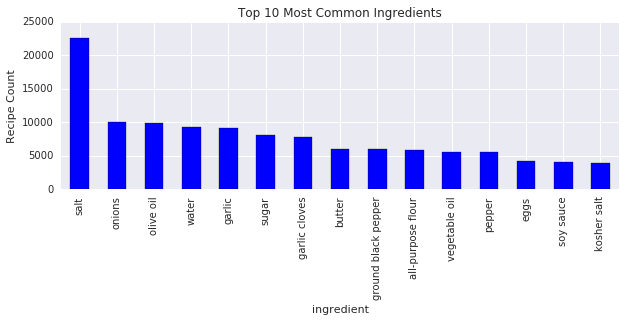

In [6]:
plt.figure(figsize=(10,3));
plt.title("Top 10 Most Common Ingredients")
plt.ylabel("Recipe Count")
plot = counts['count'].head(15).plot(kind='bar')

## Fuzzy Matching
Humm, there is both garlic and chopped garlic in the top 20 list of ingredients
How many items are like that? Let me fuzzy match the ingredients. I wonder if there's a easy way to fix that.

Unfortunately I don't think there is much I can do to fix the similar ingredients that's within the scope of the project. There doesn't appear to be a simple solution to fix this.

In [7]:
matches = []
for ingredient in counts.index:
    for ingredient2 in counts.index:
        ratio = fuzz.ratio(ingredient2, ingredient)
        if(ratio >= 70 and ingredient2 != ingredient):
            matches.append((ingredient, ingredient2, ratio))

In [8]:
relations = pd.DataFrame(matches, columns=['item1','item2','fuzz_ratio']).sort_values('fuzz_ratio', ascending=False)
relations['ranking'] = [x for x in range(1,len(relations)+1)]
relations = relations.set_index('ranking')
print('relations length:', len(relations))
relations.head(20).append(relations.tail(20))

relations length: 594


,item1,item2,fuzz_ratio
ranking,,,
1,boneless skinless chicken breast halves,boneless skinless chicken breasts,92
2,green chile,green chilies,92
3,boneless skinless chicken breasts,boneless skinless chicken breast halves,92
4,green chilies,green chile,92
5,green bell pepper,red bell pepper,88
6,red bell pepper,green bell pepper,88
7,ground red pepper,ground pepper,87
8,ground pepper,ground red pepper,87
9,red chili powder,chili powder,86


Even for fuzzy ratios of 85 and above, there are some improper matches. I mean, at rank 14, there is a match between green peas and green beans. Doing a naive replacement using fuzzy match would cause a lot of improper matches. Humm, it's beyond the scope of this project to fix this problem. After speaking to Prof. Granger and some other collegues, it may be a bit difficult to fix.

To make ingredient predictions I will try to add the probabilities that ingredients will be used for a given item. I will test doing that here.

In [9]:
df_ingredient_relations = pd.DataFrame(ingredient_relations)

Created a vectorized dataframe for ingredients. Each column shows how often each ingredient was in the same recipe as another ingredient.

In [10]:
df_ingredient_relations.head(5)

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yuzu,yuzu juice,za'atar,zabaglione,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
( oz.) tomato sauce,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
( oz.) tomato paste,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(10 oz.) frozen chopped spinach,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(10 oz.) frozen chopped spinach, thawed and squeezed dry",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(14 oz.) sweetened condensed milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will later be doing probabilities that each ingredient can be selected from each ingredient. I don't want those to appear in the vectorization dataframe, so it will appear in a seperate table.

In [11]:
df_ingredient_relations_stats = pd.DataFrame(index=df_ingredient_relations.index)

In [12]:
df_ingredient_relations_stats['list_size'] = df_ingredient_relations.apply(np.sum, axis=1)

There are some pretty interesting ingredients in this list. There are yoghurt and yogurt. There is also yuzu, zinfandel, and other ingredients I never heard of. Unfortunately when it comes to yoghurt and yogurt, a bit out of scope to combine these. Ideally it would be great if they were combined. 

In [13]:
df_ingredient_relations_stats

,list_size
( oz.) tomato sauce,175
( oz.) tomato paste,108
(10 oz.) frozen chopped spinach,27
"(10 oz.) frozen chopped spinach, thawed and squeezed dry",21
(14 oz.) sweetened condensed milk,16
(14.5 oz.) diced tomatoes,70
(15 oz.) refried beans,32
1% low-fat buttermilk,51
1% low-fat chocolate milk,11
1% low-fat cottage cheese,199


Some of the values such as zucchini seem to be accoring too often, but after doing more testing, it seems okay.

In [14]:
print('Counts\n'
      '1% low-fat milk:', df_ingredient_relations.loc['1% low-fat milk'].sum(),
      'yukon gold potatoes:', df_ingredient_relations.loc['yukon gold potatoes'].sum(),
      'potatoes', df_ingredient_relations.loc['potatoes'].sum())

Counts
1% low-fat milk: 2474.0 yukon gold potatoes: 2892.0 potatoes 14533.0


## Suggestion exploration 
For suggestions we will look at:
- just combining the relation Counters and selecting the highest counts 
- converting the relation Counters to percentages then joining (This will be explored in Modeling)
- combining the relation Counters and selection a random ingredient from the weighted list (This will be explored in Modeling)

Testing getting an item suggestion by combining counters. A combined_relations function is made to combine two counters and remove redundant entries. For example, if we have a list of ['eggs','flour'] we don't want any 'egg's or 'flour's in the list. We also don't want any suggestions of eggs if we already have eggs in our basket. Our suggestion function will select the n top most counted ingredients in the combined relation. 

In [15]:
def combine_relations(indexes, relations):
    """Returns combined collection.Counters which do not have redundancies

    Keyword arguments:
    indexes-- columns to look at in relations Counter dictionary
    relations-- relations dictionary which includes the collections.Counters for each ingredient
    """
    combined = collections.Counter()
    for x in indexes:
        if x in relations:
            combined = combined + relations[x]
        else:
            #pass if item is not in relations table
            pass
    for x in indexes:
        if x in combined:
            del combined[x]
        else:
            #pass if item is not in combined relation
            pass
    return combined

def suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions based on the most common items in combined paramater

    Keyword arguments:
    combined-- the combined collection.Counter used for prediction 
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    if ignore != None:
        temp_selected = temp_selected + ignore
    drawn = []
    for x in combined.most_common():
        if x[0] in temp_selected:
            pass
        else:
            temp_selected.append(x[0])
            drawn.append(x[0])
            if len(drawn) == n:
                break
    return drawn

In [16]:
combined = ingredient_relations['milk'] + ingredient_relations['cheese']
assert combined['milk'] != 0
combined = combine_relations(['milk','cheese'], ingredient_relations)
assert combined['milk'] == 0
assert suggestion(combined, ['salt'], 12) == \
['butter',
 'all-purpose flour',
 'eggs',
 'sugar',
 'onions',
 'large eggs',
 'baking powder',
 'water',
 'pepper',
 'unsalted butter',
 'flour',
 'olive oil']
assert suggestion(combined, ['salt'], 5, ignore=['butter','eggs']) == \
['all-purpose flour',
 'sugar',
 'onions',
 'large eggs',
 'baking powder']

#empty relations test
missing_relations = combine_relations(['pizzapieice'], ingredient_relations)
missing_relations_suggestion = suggestion(missing_relations, ['also', 'invalid'], 10)
assert missing_relations == collections.Counter()
assert missing_relations_suggestion == []
assert len(missing_relations_suggestion) == 0

#some dirty input test
dirty_relations = combine_relations(['ice_cream', 'bananas', 'toys'], ingredient_relations)
dirty_cart = ['ice_cream', 'bananas', 'toys']
dirty_suggestion = suggestion(dirty_relations, dirty_cart, 5)
assert sum(dirty_relations.values()) != 0
assert len(dirty_suggestion) == 5

Here is an example use of the ingredient suggestor. If I have ice cream, bananas, and toys in my cart, I would be suggested to get ['salt', 'sugar', 'vanilla extract', 'butter', 'all-purpose flour'].

In [17]:
cart_relations = combine_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
cart = ['ice_cream', 'bananas', 'toys']
print('Your cart:', cart, '\n',
      'Suggestions:', suggestion(cart_relations, cart, 5))

Your cart: ['ice_cream', 'bananas', 'toys'] 
 Suggestions: ['salt', 'sugar', 'vanilla extract', 'butter', 'all-purpose flour']


Here is an interactive of the ingredient suggestion. Note that not much is going to change due to the naive algorithm that is implemented.

In [18]:
def cart_example(add):
    """Function used to setup interact for suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', suggestion(cart_relations, cart, 10))
interact(cart_example, add='text', __manual=True);

Pickling the vectorization chart, the count charts, and for use during modeling.

In [19]:
pickle.dump( df_ingredient_relations, open( "/data/BobbyDobo/df_ingredient_relations.p", "wb"))
pickle.dump( counts, open( "/data/BobbyDobo/ingredient_counts.p", "wb" ) )

In conclusion, the dataset appears to have many usual recipies in it. I've been able to implement a naive ingredient suggestor. In the next notebook, I will be exploring more ways to implement an ingredient suggestor.